In [1]:
import aligater as ag

In [2]:
metaDict, fcsDF = ag.parse("/media/ludvig/Project_Storage/GAIM/data/GAIM_fcs/01-03-2016/plate 1/B cells_A2_A02_030.fcs",output_format='DataFrame')

In [3]:
fcsDF

,FSC-A,FSC-H,SSC-A,SSC-H,IgA,CD27,CD34,CD19,IgD,CD45,CD38,CD24,Time
0,111976.828125,94665.0,78134.679688,62367.0,97.299995,80.620003,276.609985,54.209999,427.950012,-4.050000,90.720001,92.880005,4.100000
1,132292.203125,114094.0,23395.089844,17288.0,94.519997,104.250000,51.430000,-2.780000,206.550003,89.099998,36.720001,95.040001,23.100000
2,151015.468750,114145.0,128109.351562,84739.0,223.789993,275.220001,489.279999,161.240005,109.349998,-8.100000,152.279999,93.960007,23.100000
3,88098.812500,67622.0,63862.160156,46528.0,134.830002,219.619995,546.270020,20.850000,218.699997,-25.650000,9.720000,7.560000,42.700001
4,65475.332031,58582.0,18682.990234,13977.0,18.070000,84.790001,-40.310001,-8.340000,-9.450000,10.800000,7.560000,-68.040001,42.799999
5,191066.796875,140526.0,70475.781250,49210.0,12.510000,58.380001,69.500000,-6.950000,91.800003,-66.150002,12.960001,7.560000,44.900002
6,71329.562500,57043.0,96631.406250,67000.0,76.449997,251.589996,261.320007,52.820000,28.350000,0.000000,12.960001,14.040001,49.599998
7,70806.687500,66183.0,13464.929688,11207.0,54.209999,91.739998,11.120000,20.850000,-12.150001,39.150002,10.800000,119.880005,53.599998
8,163754.015625,112517.0,128433.218750,88520.0,152.899994,170.970001,191.819992,0.000000,220.050003,-20.250000,48.600002,211.680008,54.299999
9,108027.031250,89461.0,52846.410156,40207.0,6.950000,25.020000,29.190001,-23.629999,193.050003,63.450001,19.440001,-51.840004,55.599998


In [4]:
gate = ag.getGatedVector(fcsDF, "FSC-A")

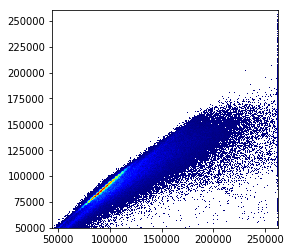

In [6]:
ag.plotHeatmap(fcsDF, "FSC-A","FSC-H")